In [1]:
 #librerie
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from google.colab import drive
from scipy import integrate
from time import sleep
from scipy.optimize import curve_fit

from os import listdir
from os.path import isfile, join
import os

import warnings

import sys
from termcolor import colored, cprint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Select the directory from which you have to parse the data

In [3]:
###########################################
#                                         #
#    CHANGE ONLY THIS CELL IN THE CODE    #
#                                         #
###########################################

data_dir="/content/drive/MyDrive/Lab HPGE/Data"        
source="/Ba133"                               
detector="/Ge"                                
threshold_caen="150"                         


gain_preampl="30" #useful only for germanium detector

In [5]:
threshold="/THR_"+threshold_caen
gain="__GAIN_"+gain_preampl

path_to_plots="/content/drive/MyDrive/Lab HPGE/Data/Plots/"  
path_to_simulations=data_dir+"/Simulations"

if detector[1:]=="Ge":
    path_to_directory=data_dir+detector+source+threshold+gain   # do not change this. Change the part above
elif detector[1:]=="NaI":
    path_to_directory=data_dir+detector+source+threshold        # do not change this. Change the part above

Set up:


In [6]:
warnings.filterwarnings("ignore")

sample_space=10e-9 #10 ns
samples_per_event=8192 

time_axis=np.linspace(sample_space,samples_per_event*sample_space,samples_per_event)  # from 10 ns to 8192*10 ns 
samples_axis=np.linspace(1,8192,8192) # from 1 to 8192



    #             _________________
    #            /|               |\
    #           / |               | \
    # ---------/---------------------\-------------------
    #_________/   |               |   \______________
    #         |   |    plateau    |   |
    #         |   |               |   |
    # small   |   |___            |   |_     small points
    # points  | graph |           |graph|       dx
    #  sx     |   sx  |           | dx  |
    #
    #


saturation_point=16383 #limit points saturation
threshold_value=50

def gaussian(x, N, mu,sigma):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)

def gaussianh(x, N, mu,sigma,h):
    return N * np.exp(-0.5*((x-mu)/sigma)**2)+h

def polynomial(x,b,c,d,e):
    return b*x**3 + c*x**2 + d*x + e

Names of the files in the directory

In [7]:
try:
    files_name_xml = ["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name)) and file_name[-3:]=="xml"]
    print("Xml:   ", files_name_xml)
    sat_file_name=[file_name[:-4]+"_sat.txt" for file_name in files_name_xml]
    unsat_file_name=[file_name[:-4]+"_unsat.txt" for file_name in files_name_xml]
    print("Sat:   ", sat_file_name)
    print("Unsat: ", unsat_file_name)
except:
    print("Folder not found!. Check if the values two cells above are correct.")

Xml:    ['/Ge_Ba133_150_g30_1.xml', '/Ge_Ba133_150_g30_2.xml', '/Ge_Ba133_150_g30_3.xml', '/Ge_Ba133_150_g30_4.xml', '/Ge_Ba133_150_g30_5.xml', '/Ge_Ba133_150_g30_6.xml', '/Ge_Ba133_150_g30_7.xml', '/Ge_Ba133_150_g30_8.xml', '/Ge_Ba133_150_g30_9.xml', '/Ge_Ba133_150_g30_10.xml', '/Ge_Ba133_150_g30_11.xml', '/Ge_Ba133_150_g30_12.xml', '/Ge_Ba133_150_g30_13.xml', '/Ge_Ba133_150_g30_14.xml', '/Ge_Ba133_150_g30_15.xml', '/Ge_Ba133_150_g30_16.xml', '/Ge_Ba133_150_g30_17.xml', '/Ge_Ba133_150_g30_18.xml']
Sat:    ['/Ge_Ba133_150_g30_1_sat.txt', '/Ge_Ba133_150_g30_2_sat.txt', '/Ge_Ba133_150_g30_3_sat.txt', '/Ge_Ba133_150_g30_4_sat.txt', '/Ge_Ba133_150_g30_5_sat.txt', '/Ge_Ba133_150_g30_6_sat.txt', '/Ge_Ba133_150_g30_7_sat.txt', '/Ge_Ba133_150_g30_8_sat.txt', '/Ge_Ba133_150_g30_9_sat.txt', '/Ge_Ba133_150_g30_10_sat.txt', '/Ge_Ba133_150_g30_11_sat.txt', '/Ge_Ba133_150_g30_12_sat.txt', '/Ge_Ba133_150_g30_13_sat.txt', '/Ge_Ba133_150_g30_14_sat.txt', '/Ge_Ba133_150_g30_15_sat.txt', '/Ge_Ba133_150_g

Parsing all the xml files and creating a txt file for each of them containing the values of the integrals



In [8]:
files_in_directory=["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name))]

files_names=zip(files_name_xml,sat_file_name,unsat_file_name)
#output of the code below: a txt file for each xml file that contains all the events of that run 

###############################################
#                                             #
#               GERMANIUM                     #
#                                             #
###############################################



if detector[1:]=="Ge":
    for xml_name,sat_name,unsat_name in files_names:
        if sat_name in files_in_directory and unsat_name in files_in_directory:
            print("\n##################################################################################\n")
            print("Files: ",sat_name," and ",unsat_name , " already present in: ",path_to_directory)
            print("\n")
        else:
            print("\n##################################################################################\n")
            print("Start working on: ",xml_name)

            list_event=[]
            maxima_peaks=[]
            cupola=[]
            index_saturated=[]

            non_sat_values_integrals=[]
            sat_values_integrals=[]
            index_problematic=[]

            path_to_file=path_to_directory+xml_name
            tree = ET.parse(path_to_file) 
            root=tree.getroot()
            
            for event in root.findall("event"):  #this finds all the event in the file
                string_event=event.find("trace").text  #this takes all the samples for each event
                int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
                list_event.append(int_event)
            
            list_event_array=np.array(list_event)

            print("Parsing of  ",xml_name, " completed!")
            print("Start working on saturation problem.")
            

            maxima_peaks=np.zeros(len(list_event_array))
            list_event_array.max(axis=1,out=maxima_peaks)
            index_saturated=[i for i in range(len(maxima_peaks)) if(maxima_peaks[i]==saturation_point)]

            for index_event in index_saturated:
                sx=[]
                dx=[]
                graph_sx=[]
                graph_dx=[]
                small_points_dx=[]
                small_points_sx=[]
                plateau_points=[]



                event=list_event_array[index_event] #select the event

                #dividing the event in 5 parts on the x-axis...
                plateau_points=[i for i in range(len(event)) if(event[i]==saturation_point)]

                small_points_sx=[i for i in range(len(event)) if(event[i]<threshold_value and i<plateau_points[0])]
                sx=[i for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
                dx=[i for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]
                small_points_dx=[i for i in range(len(event)) if(event[i]<threshold_value and i>plateau_points[0])]
                
                # ... and in 2 in the y axis
                graph_sx=[event[i] for i in range(plateau_points[0]) if(event[i]>=threshold_value and event[i]<saturation_point)]
                graph_dx=[event[i] for i in range(plateau_points[0],len(event)) if(event[i]>=threshold_value and event[i]<saturation_point)]

                #filling the right arrays
                x_graph=np.zeros(len(sx)+len(dx))
                np.concatenate((sx,dx),out=x_graph)
                graph=np.zeros(len(graph_sx)+len(graph_dx))
                np.concatenate((graph_sx,graph_dx),out=graph)
                graph_small_points_sx =event[small_points_sx]
                graph_small_points_dx = event[small_points_dx]

                #fit
                try:
                    init_vals = [saturation_point,plateau_points[int(len(plateau_points)/2)] ,len(plateau_points)]  # for [N,mu, wid]
                    best_vals, covar = curve_fit(gaussian, x_graph, graph,p0=init_vals)
                    
                    gaussian_event=gaussian(samples_axis,*best_vals)
                    cupola.append(np.concatenate((graph_small_points_sx,graph_sx,gaussian_event[plateau_points],graph_dx,graph_small_points_dx)))
                except:
                    index_problematic.append(index_event)

            tot_events=len(list_event_array)
            non_saturated_events = np.delete(list_event_array,index_saturated,axis=0)

            non_sat_values_integrals=[integrate.trapz(event,time_axis) for event in non_saturated_events] #evaluating the spectrum
            sat_values_integrals=[integrate.trapz(event,time_axis) for event in cupola]

            print("Integrals calculation of saturated and unsaturated events of: ",xml_name, " completed!")
            
            tot_sat_events=len(sat_values_integrals)
            tot_unsat_events=len(non_sat_values_integrals)
            tot_lost_events=len(index_problematic)
            

            print("\n##################################################################\n")
            print("Stats on this run: \n\t 1) Total events: \t{:d} \n\t 2) Sat. Events: \t{:d} ({:f}) % \n\t 2) UnSat. Events: \t{:d} ({:f}) % \n\t 2) Lost Events: \t{:d} ({:f}) %".format(tot_events,tot_sat_events,float(tot_sat_events)*100/tot_events,tot_unsat_events,float(tot_unsat_events)*100/tot_events,tot_lost_events,float(tot_lost_events)*100/tot_events))
            print("\n##################################################################\n")



            np.savetxt(path_to_directory+sat_name,sat_values_integrals)
            print("File: ",sat_name, "saved in the folder: ",path_to_directory)
            np.savetxt(path_to_directory+unsat_name,non_sat_values_integrals)
            print("File: ",unsat_name, "saved in the folder: ",path_to_directory)

            print("\n")

    print("\n##################################################################################\n")
###############################################
#                                             #
#                  NAI                        #
#                                             #
###############################################

elif detector[1:]=="NaI":
    for xml_name,sat_name,unsat_name in files_names:
         if sat_name in files_in_directory and unsat_name in files_in_directory:
            print("\n##################################################################################\n")
            print("Files: ",sat_name," and ",unsat_name , " already present in: ",path_to_directory)
            print("\n")
         else:
            print("\n##################################################################################\n")
            print("Start working on: ",xml_name)
            path_to_file=path_to_directory+xml_name
            tree = ET.parse(path_to_file) 
            root=tree.getroot()
            
            list_event=[]
            index_saturated=[]
            minima_peaks=[]
            
            index_problematic=[]

            sat_events=[]
            non_sat_values_integrals=[]
            sat_values_integrals=[]         

            for event in root.findall("event"):  #this finds all the event in the file
                string_event=event.find("trace").text  #this takes all the samples for each event
                int_event=[int(string_number) for string_number in string_event.split()] #splitting and casting to int
                list_event.append(int_event)
            
            print("Parsing of  ",xml_name, " completed!")
            print("Start working on saturation problem.")
            
            list_event_array=np.array(list_event)
            minima_peaks=np.zeros(len(list_event_array))
            list_event_array.min(axis=1,out=minima_peaks)
            index_saturated=[i for i in range(len(minima_peaks)) if(minima_peaks[i]==0)]

            #baseline=list_event_array[:][0:200]
            #np.append(baseline,list_event_array[:][-200:])
            #baseline=np.mean(baseline)
            baseline=list_event[0][8100]
            background_value_NaI=baseline
            
            list_event_array=list_event_array-background_value_NaI     
            list_event_array=(-1)*list_event_array

            tot_events=len(list_event_array)
            list_event=[]
           
#            z=0
#            k=0
#            j=0                                 DEBUGGING
#            l=0
#            prova_1=[]
#            prova_2=[]
            for index_event in index_saturated:
                sx=[]
                dx=[]
                saturated_interval=[]
                x_event=[]
                
                graph_dx=[]
                graph_sx=[]
                graph_saturated=[]
                graph_smooth=[]


                event=list_event_array[index_event]
                

                #Dividing the waveform in parts on the x-axis...
                sat_start=8192
                sat_end=0
                for i in range(len(event)):
                    if (event[i]==saturation_point and i<sat_start):
                        sat_start=i
                    if (event[i]==saturation_point and i>sat_end):
                        sat_end=i
                if sat_start!=sat_end:
                    saturated_interval=[i for i in range(sat_start,sat_end,1)] #saturated interval (first and last saturated points included)
                else:
                    saturated_interval.append(sat_start)
                #saturated_interval=[i for i in range(saturated_interval[0],saturated_interval[-1],1)] # continuous range from the line above
                sx=[i for i in range(0,saturated_interval[0],1)] #from 0 included to first saturation point excluded
                x_event=[i for i in range(saturated_interval[-1]+1,len(event),1) if event[i]>=1] # (last sat point,last event >1]
                x_event=[i for i in range(x_event[0],x_event[-1],1)] # continuous range from the line above
                dx=[i for i in range(x_event[-1]+1,len(event),1)] # (last event >1,8192)
                
                #... and on the y axis
                graph_sx=event[sx]

                graph_dx=event[dx]
                
                #              ---------------------- \
                #              |                     |  \
                #              |                     |    \
                #              |                     |      \
                # _____________|                     |       \_________________
                # -------------|---------------------|---------|--------------  zero line (baseline)
                #              |                     |         |
                #       sx    )|       [sat. int.]   |(x_event]|     (dx]
                #
                #
                #
                

                try:
                    #fit
                    best_vals, covar = curve_fit(polynomial, x_event, event[x_event])
                    graph_saturated=[polynomial(x,*best_vals) for x in saturated_interval]
                    graph_smooth=[polynomial(x,*best_vals) for x in x_event]
                    #reconstructed waveform
                    reconstructed_wf=np.concatenate((graph_sx,graph_saturated,graph_smooth,graph_dx))
                    #adding this last wf in the sat. waveforms
                    sat_events.append(reconstructed_wf)

#                    if len(reconstructed_wf)==8191:
#                        z+=1
#                        prova_1.append(np.concatenate((sx,saturated_interval,x_event,dx)))
#                                        
#                        for i in range(len(saturated_interval)-1):
#                            if saturated_interval[i+1]!=(saturated_interval[i]+1):
#                                print("AAAAAAAA 8191          ", index_event)
#
#                                break 
#                    elif len(reconstructed_wf)==8193:                                            DEBUGGING
#                        k+=1          
#                    elif len(reconstructed_wf)==8192:
#                        j+=1
#                    elif len(reconstructed_wf)==8190:
#                        l+=1
#                        prova_2.append(np.concatenate((sx,saturated_interval,x_event,dx)))
#                        for i in range(len(saturated_interval)-1):
#                            if saturated_interval[i+1]!=(saturated_interval[i]+1):
#                                print("AAAAAAAA  8190         ", index_event )
#                                break

                except:
                    index_problematic.append(index_event)
#            print(len(index_saturated))
#            print(len(index_problematic))
#            print("8191 ", z)                           DEBUGGING
#            print("8193 ",k)
#            print("8192 ",j)
#            print("8190 ",l)
#            print(z+k+j+l)

            
            non_saturated_events = np.delete(list_event_array,index_saturated,axis=0)

            non_sat_values_integrals=[integrate.trapz(event,time_axis) for event in non_saturated_events] #evaluating the spectrum
            sat_values_integrals=[integrate.trapz(event,time_axis) for event in sat_events]

            print("Integrals calculation of saturated and unsaturated events of: ",xml_name, " completed!")
            
            tot_sat_events=len(sat_values_integrals)
            tot_unsat_events=len(non_sat_values_integrals)
            tot_lost_events=len(index_problematic)

            print("\n##################################################################\n")
            print("Stats on this run: \n\t 1) Total events: \t{:d} \n\t 2) Sat. Events: \t{:d} ({:f} %) \n\t 2) UnSat. Events: \t{:d} ({:f} %) \n\t 2) Lost Events: \t{:d} ({:f} %)".format(tot_events,tot_sat_events,float(tot_sat_events)*100/tot_events,tot_unsat_events,float(tot_unsat_events)*100/tot_events,tot_lost_events,float(tot_lost_events)*100/tot_events))
            print("\n##################################################################\n")


            np.savetxt(path_to_directory+sat_name,sat_values_integrals)
            print("File: ",sat_name, "saved in the folder: ",path_to_directory)
            np.savetxt(path_to_directory+unsat_name,non_sat_values_integrals)
            print("File: ",unsat_name, "saved in the folder: ",path_to_directory)

            print("\n")
   
    print("\n##################################################################################\n")            
else:
    print("Detector not available!")


##################################################################################

Files:  /Ge_Ba133_150_g30_1_sat.txt  and  /Ge_Ba133_150_g30_1_unsat.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30



##################################################################################

Files:  /Ge_Ba133_150_g30_2_sat.txt  and  /Ge_Ba133_150_g30_2_unsat.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30



##################################################################################

Files:  /Ge_Ba133_150_g30_3_sat.txt  and  /Ge_Ba133_150_g30_3_unsat.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30



##################################################################################

Files:  /Ge_Ba133_150_g30_4_sat.txt  and  /Ge_Ba133_150_g30_4_unsat.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30



#######################

Merging all the integral files in 3 separated txt files:


1. Sat_files: all the integrals values that correspond to saturated events
2. Unsat_files: all the integrals values that correspond to saturated events
3. All: all in one file (1 + 2)



In [9]:
##############################################################
#IF YOU WANT TO OVERWRITE THE FILES CHANGE THIS FLAG         #
overwrite_flag=1                     #
                                                             #
# IF 0 FILES WILL NOT BE OVERWRITTEN                    #
# IF ANY VALUE OTHER THAN 0 IT WILL BE OVERWRITTEN           #
##############################################################





if detector[1:]=="Ge":
    filename_sat_all=detector+"_"+source[1:]+"_"+threshold_caen+"_g"+gain_preampl+"_"+"sat_all.txt"
    filename_unsat_all=detector+"_"+source[1:]+"_"+threshold_caen+"_g"+gain_preampl+"_"+"unsat_all.txt"
    file_name_all=detector+"_"+source[1:]+"_"+threshold_caen+"_g"+gain_preampl+"_"+"all.txt"
elif detector[1:]=="NaI":
    filename_sat_all=detector+"_"+source[1:]+"_"+threshold_caen+"_"+"sat_all.txt"
    filename_unsat_all=detector+"_"+source[1:]+"_"+threshold_caen+"_"+"unsat_all.txt"
    file_name_all=detector+"_"+source[1:]+"_"+threshold_caen+"_"+"all.txt"
else:
    print("Detector not found")


files_names=zip(sat_file_name,unsat_file_name)

files_in_directory=["/"+file_name for file_name in listdir(path_to_directory) if isfile(join(path_to_directory, file_name))]


    
if filename_sat_all in files_in_directory and filename_unsat_all in files_in_directory :
    print("File: ",filename_sat_all," and ",filename_unsat_all," already present in: ",path_to_directory)
    
    if overwrite_flag!=0:
        print("Are you sure you want to overwrite the total sat and unsat files? Type y or n)")
        answer=input()
        if answer=="y" or answer=="yes" or answer=="Y" or answer=="ye" or answer=="YES":
            os.remove(path_to_directory+filename_sat_all)
            os.remove(path_to_directory+filename_unsat_all)
            f_sat_all=open(path_to_directory+filename_sat_all, 'a')
            f_unsat_all=open(path_to_directory+filename_unsat_all, 'a')
            for sat_name,unsat_name in files_names:
                sat_integrals_value=np.loadtxt(path_to_directory+sat_name)
                unsat_integrals_value=np.loadtxt(path_to_directory+unsat_name)

                
                np.savetxt(f_unsat_all,unsat_integrals_value)
                np.savetxt(f_sat_all,sat_integrals_value)
            f_sat_all.close()
            f_unsat_all.close()
            print("Total sat and unsat files overwritten!")
        else:
            print("Files not changed.")
else:
    f_sat_all=open(path_to_directory+filename_sat_all, 'a')
    f_unsat_all=open(path_to_directory+filename_unsat_all, 'a')
    for sat_name,unsat_name in files_names:
        sat_integrals_value=np.loadtxt(path_to_directory+sat_name)
        unsat_integrals_value=np.loadtxt(path_to_directory+unsat_name)
        np.savetxt(f_sat_all,sat_integrals_value)
        np.savetxt(f_unsat_all,unsat_integrals_value)
    f_sat_all.close()
    f_unsat_all.close()
    print("Files: ",filename_sat_all," and ",filename_unsat_all," saved in the folder: ",path_to_directory)


if file_name_all in files_in_directory:
    print("File: ",file_name_all," already present in: ",path_to_directory)
    
    if overwrite_flag!=0:
        print("Are you sure you want to overwrite the total file? Type y or n)")
        answer=input()
        if answer=="y" or answer=="yes" or answer=="Y" or answer=="ye" or answer=="YES":
            os.remove(path_to_directory+file_name_all)
            f_all=open(path_to_directory+file_name_all, 'a')
            sat_integrals_value_tot=np.loadtxt(path_to_directory+filename_sat_all)
            unsat_integrals_value_tot=np.loadtxt(path_to_directory+filename_unsat_all)
            np.savetxt(f_all,sat_integrals_value_tot)
            np.savetxt(f_all,unsat_integrals_value_tot)
            f_all.close()
            print("Total file overwritten!")
        else:
            print("File: ",file_name_all, " not changed.")
else:
    f_all=open(path_to_directory+file_name_all, 'a')
    sat_integrals_value_tot=np.loadtxt(path_to_directory+filename_sat_all)
    unsat_integrals_value_tot=np.loadtxt(path_to_directory+filename_unsat_all)
    np.savetxt(f_all,sat_integrals_value_tot)
    np.savetxt(f_all,unsat_integrals_value_tot)
    print("File: ",file_name_all," saved in the folder: ",path_to_directory)
    f_all.close()

File:  /Ge_Ba133_150_g30_sat_all.txt  and  /Ge_Ba133_150_g30_unsat_all.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30
Are you sure you want to overwrite the total sat and unsat files? Type y or n)
n
Files not changed.
File:  /Ge_Ba133_150_g30_all.txt  already present in:  /content/drive/MyDrive/Lab HPGE/Data/Ge/Ba133/THR_150__GAIN_30
Are you sure you want to overwrite the total file? Type y or n)
n
File:  /Ge_Ba133_150_g30_all.txt  not changed.


Reading in the all file 

All events

In [10]:
nomefile=path_to_directory+file_name_all 
f=open(nomefile,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]

for riga in lines:
    colonna1.append(riga.split()[0])
f.close()

all_integrals_values = np.asarray(colonna1, dtype=np.float64)

All saturated events

In [11]:
nomefile_sat=path_to_directory+filename_sat_all 
f=open(nomefile_sat,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]

for riga in lines:
    colonna1.append(riga.split()[0])
f.close()

all_integrals_sat_values = np.asarray(colonna1, dtype=np.float64)

All unsaturated events

In [12]:
nomefile_unsat=path_to_directory+filename_unsat_all 
f=open(nomefile_unsat,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]

for riga in lines:
    colonna1.append(riga.split()[0])
f.close()

all_integrals_unsat_values = np.asarray(colonna1, dtype=np.float64)

Plotting the histogram

In [13]:
#numb_bins=int(np.sqrt(len(all_integrals_values)))
numb_bins=6000

if detector[1:]=="Ge":
  if source[1:]=="Ba133":
    if gain_preampl=="100":
      range_bins=(0,1)
    else: 
      range_bins=(0,0.3)  
  elif source[1:]=="Cs137":
    range_bins=(0,2.5)
  elif source[1:]=="Am241":
    range_bins=(0,0.1)
  elif source[1:]=="Na22":
    range_bins=(0,1)

elif detector[1:]=="NaI":
  if source[1:]=="Ba133":
    range_bins=(0,0.0075)
  elif source[1:]=="Cs137":
    range_bins=(0,0.00025)
  elif source[1:]=="Am241":
    range_bins=(0,0.007)

Total events: 394526







Saturated events in this run: 0.344 %   (1357)
Un-Saturated events in this run: 99.656 %   (393169)


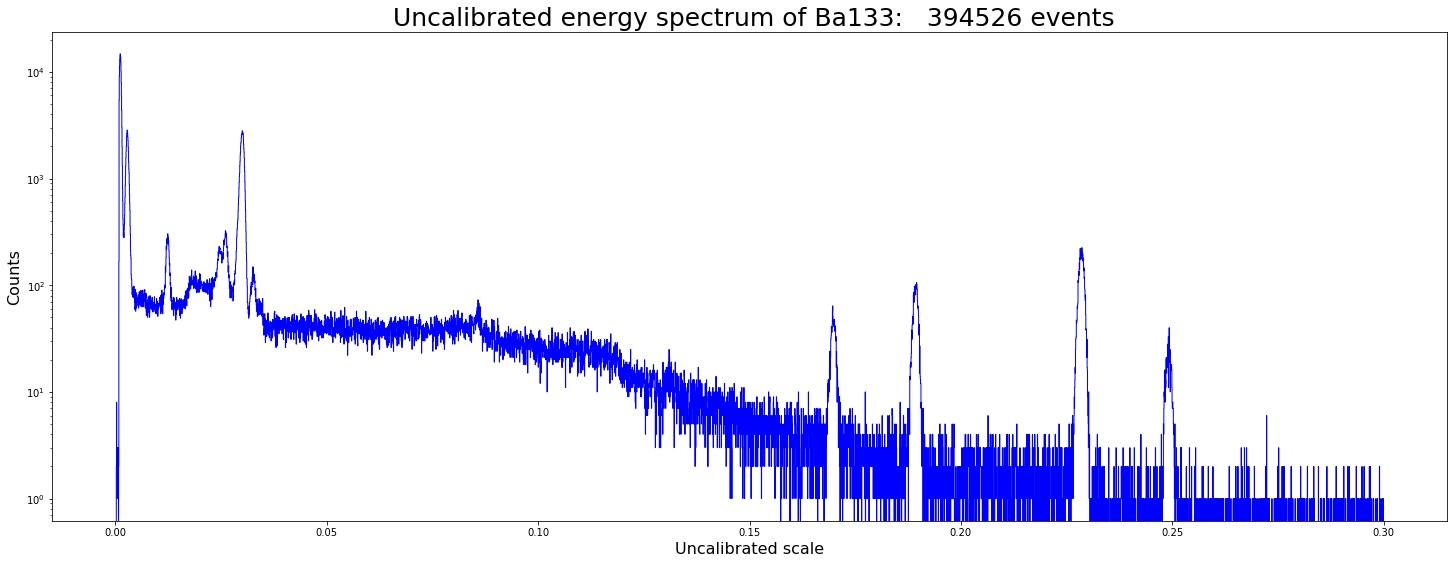

In [14]:
#histogram of the spectrum for all data of Barium
perc_sat=len(all_integrals_sat_values)*100/len(all_integrals_values)
perc_unsat=len(all_integrals_unsat_values)*100/len(all_integrals_values)


len_tot=len(all_integrals_values)
print("Total events: {:d}".format(len_tot))

print("\n\n")



 #try to change this maybe
plt.figure(figsize=(25,9))
histogram=plt.hist(all_integrals_values,bins=numb_bins,histtype="step",color="blue",range=range_bins)

#grandezze legate ai bin
value=histogram[0]  
sigma_value=np.sqrt(value)
center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
center_bins=np.array(center_bins)

#plt.bar(center_bins,value,yerr=sigma_value,alpha=0)
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(0.26,0.27) #primi picchi
#plt.xlim(0.18,0.30) #ultimi picchi
#plt.grid()
plt.yscale("log")


print("\n\n")
print(colored("\nSaturated events in this run: {:.3f} %   ({:d})","red").format(perc_sat,len(all_integrals_sat_values)))
print(colored("Un-Saturated events in this run: {:.3f} %   ({:d})","blue").format(perc_unsat,len(all_integrals_unsat_values)))

plt.title(" Uncalibrated energy spectrum of {:s}:   {:d} events".format(source[1:],len(all_integrals_values)),fontsize=25)
plt.xlabel("Uncalibrated scale",fontsize=16)
plt.ylabel("Counts",fontsize=16)

#plt.savefig(path_to_plots+"NaI_Cs137_SPECTRUM.png")

plt.show()

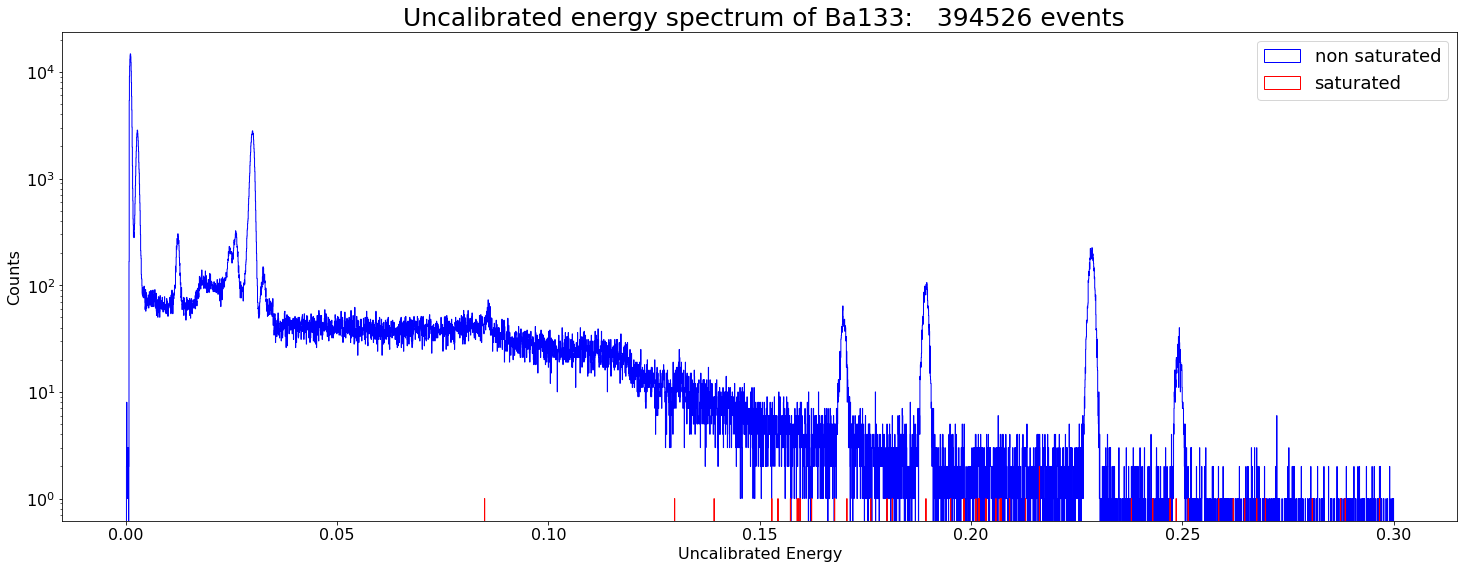

In [15]:
plt.figure(figsize=(25,9))
plt.hist((all_integrals_sat_values,all_integrals_unsat_values),bins=numb_bins,histtype="step",color=("red","blue"),stacked=True,label=("saturated","non saturated"),range=range_bins)
#plt.ylim(0,2000)
#plt.xlim(0.24,0.26)
#plt.hist(sat_values_integrals,bins=numb_bins,histtype="step",color="blue",range=(0.0,0.8),stacked=True)
plt.yscale("log")

plt.title(" Uncalibrated energy spectrum of {:s}:   {:d} events".format(source[1:],len(all_integrals_values)),fontsize=25)
plt.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Uncalibrated Energy",fontsize=16)
plt.ylabel("Counts",fontsize=16)

#plt.savefig(path_to_plots+"NaI_Am241_SPECTRUM_UNC.png")

plt.show()

Calibration part

In [16]:
#picchi più alti per Ba133 estrapolati dalle tabelle
if gain_preampl=="100":
  if source[1:]=="Ba133":
    E_real_peaks=[30.973,34.920,53.161,80.9971,276.398,302.853,356.017,383.851] #keV 
    E_real_peaks=np.array(E_real_peaks)
    x_uncalibrated_peaks=[0.036,0.049,0.086,0.151,0.615,0.68,0.812,0.88]
    x_uncalibrated_peaks=np.array(x_uncalibrated_peaks)
  elif source[1:]=="Cs137":
    pass

#stima spacca e pesa dal grafico -->incertezza notevole

if gain_preampl=="30":
  if source[1:]=="Ba133":
    E_real_peaks=[30.973,34.920,53.161,80.9971,276.398,302.853,356.017,383.851] #keV 
    E_real_peaks=np.array(E_real_peaks)
    # BARIO DISCO
    #x_uncalibrated_peaks=[0.0065,0.009,0.02,0.0395,0.183,0.202,0.242,0.263]
    #BARIO SIM CARD (freddissimo, brrrrrrrrrrrrrr)
    x_uncalibrated_peaks=[0.0012,0.003,0.013,0.03,0.17,0.19,0.23,0.25]
    x_uncalibrated_peaks=np.array(x_uncalibrated_peaks)
  elif source[1:]=="Cs137":
    pass

Plotting the peaks

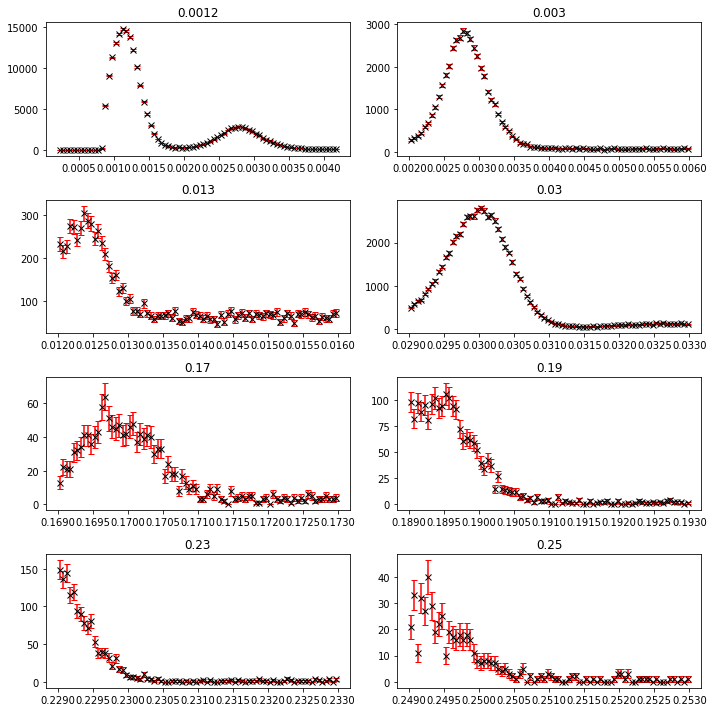

In [17]:
plt.figure(figsize=(10,10))

n_rows=round(len(x_uncalibrated_peaks)/2)
n_cols=2
#n_rows=3
#n_cols=3
k=1

pt_sx=20
pt_dx=60

for Xpeak in x_uncalibrated_peaks: 
    for i in range(len(center_bins)):
        if(center_bins[i] > Xpeak):
            plt.subplot(n_rows,n_cols,k)
            #plt.plot(center_bins[i-pt_sx:i+pt_dx],value[i-pt_sx:i+pt_dx],ls="",marker="x",markersize=8)
            plt.errorbar(center_bins[i-pt_sx:i+pt_dx],value[i-pt_sx:i+pt_dx],yerr=np.sqrt(value[i-pt_sx:i+pt_dx]),fmt="x",color="Black",ecolor="red",capsize=3)
            plt.title(Xpeak)
            k+=1
            break    
plt.tight_layout()

Gaussian fit on each peak 

In [19]:
all_mu=[0]*len(x_uncalibrated_peaks)
all_sigmaMu=[0]*len(x_uncalibrated_peaks)

all_sigma=[0]*len(x_uncalibrated_peaks)
all_sigmaSigma=[0]*len(x_uncalibrated_peaks)

all_N=[0]*len(x_uncalibrated_peaks)
all_sigmaN=[0]*len(x_uncalibrated_peaks)

all_H=[0]*len(x_uncalibrated_peaks)
all_sigmaH=[0]*len(x_uncalibrated_peaks)

best_i_sx=[0]*len(x_uncalibrated_peaks)
best_i_dx=[0]*len(x_uncalibrated_peaks)

best_bins=[0]*len(x_uncalibrated_peaks)

k=0


central_bins=int(np.sqrt(len_tot))
bins_at_left=6000
bins_at_right=6002

for Xpeak in x_uncalibrated_peaks:
  err_mu_best=1.
  err_sigma_best=25.
  for numb_bins_fit in range(central_bins+bins_at_left,central_bins+bins_at_right):
    
    histogram=np.histogram(all_integrals_values,bins=numb_bins_fit,range=range_bins)
    value=histogram[0]  
    center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins=np.array(center_bins)
    flag=0

    for i in range(len(center_bins)):
      if(center_bins[i] > Xpeak and flag==0):
        for i_sx in range(5,120):
          for i_dx in range(5,120):
            err_mu_perc=10000
            err_sigma_perc=10000
            try:
              init_vals = [value[i],Xpeak ,(center_bins[i+1]-center_bins[i-1])/2.,value[i-i_sx]]
              best_vals_gauss, covar_gauss = curve_fit(gaussianh,center_bins[i-i_sx:i+i_dx],value[i-i_sx:i+i_dx],sigma=np.sqrt(value[i-i_sx:i+i_dx]),p0=init_vals) 

              err_mu_perc=np.sqrt(covar_gauss[1][1])*100/best_vals_gauss[1]
              err_sigma_perc=np.sqrt(covar_gauss[2][2])*100/abs(best_vals_gauss[2])
            except:
              pass

            if (err_mu_perc< err_mu_best and err_sigma_perc<err_sigma_best) :
              all_mu[k]=best_vals_gauss[1]
              all_sigmaMu[k]=covar_gauss[1][1]

              all_sigma[k]=best_vals_gauss[2]
              all_sigmaSigma[k]=covar_gauss[2][2]

              all_N[k]=best_vals_gauss[0]
              all_sigmaN[k]=covar_gauss[0][0]

              all_H[k]=best_vals_gauss[3]
              all_sigmaH[k]=covar_gauss[3][3]

              best_i_dx[k]=i_dx
              best_i_sx[k]=i_sx

              best_bins[k]=numb_bins_fit
              err_mu_best=err_mu_perc
              err_sigma_best=err_sigma_perc

            else: 
              pass
        flag=1
  print("Peak at: ",E_real_peaks[np.argwhere(x_uncalibrated_peaks==Xpeak)],"[keV] ", "  bins: ",best_bins[k],"\t    mu: {:.5f}".format(all_mu[k]),"  \t err_mu {:.5f}[%]: ".format(np.sqrt(all_sigmaMu[k])*100/all_mu[k]), "\t sigma {:.5f}  ".format(abs(all_sigma[k])),"  \t err_sigma {:.5f}[%] ".format(np.sqrt(all_sigmaSigma[k])*100/abs(all_sigma[k])))
  k+=1


all_mu=np.array(all_mu)
all_sigmaMu=np.array(all_sigmaMu)
all_sigma=np.array(all_sigma)

Peak at:  [[30.973]] [keV]    bins:  6628 	    mu: 0.00114   	 err_mu 0.07614[%]:  	 sigma 0.00023     	 err_sigma 3.85737[%] 
Peak at:  [[34.92]] [keV]    bins:  6628 	    mu: 0.00280   	 err_mu 0.09271[%]:  	 sigma 0.00032     	 err_sigma 0.71796[%] 
Peak at:  [[53.161]] [keV]    bins:  6629 	    mu: 0.01235   	 err_mu 0.06184[%]:  	 sigma 0.00034     	 err_sigma 2.14584[%] 
Peak at:  [[80.9971]] [keV]    bins:  6629 	    mu: 0.02998   	 err_mu 0.01299[%]:  	 sigma 0.00043     	 err_sigma 0.86398[%] 
Peak at:  [[276.398]] [keV]    bins:  6629 	    mu: 0.16979   	 err_mu 0.01022[%]:  	 sigma 0.00055     	 err_sigma 2.92812[%] 
Peak at:  [[302.853]] [keV]    bins:  6629 	    mu: 0.18927   	 err_mu 0.00612[%]:  	 sigma 0.00057     	 err_sigma 1.81341[%] 
Peak at:  [[356.017]] [keV]    bins:  6629 	    mu: 0.22850   	 err_mu 0.00372[%]:  	 sigma 0.00063     	 err_sigma 1.43332[%] 
Peak at:  [[383.851]] [keV]    bins:  6628 	    mu: 0.24913   	 err_mu 0.00915[%]:  	 sigma 0.00073     	 er

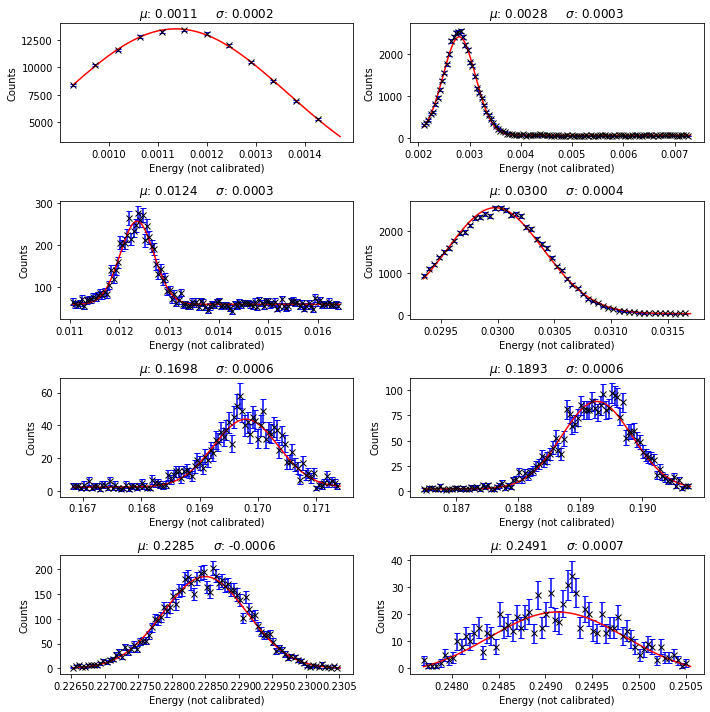

In [20]:
plt.figure(figsize=(10,10))

n_rows=round(len(x_uncalibrated_peaks)/2)
#n_rows=3
n_cols=2
k=1

for Xpeak in x_uncalibrated_peaks:
    histogram=np.histogram(all_integrals_values,bins=best_bins[k-1],range=range_bins)
    value=histogram[0]  
    center_bins=[0.5*(histogram[1][i]+histogram[1][i+1]) for i in range(len(histogram[1])-1)]
    center_bins=np.array(center_bins) 
    for i in range(len(center_bins)):
        if(center_bins[i] > Xpeak):

            x_gauss=np.linspace(center_bins[i-best_i_sx[k-1]],center_bins[i+best_i_dx[k-1]],1000)
            plt.subplot(n_rows,n_cols,k)
            plt.errorbar(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],yerr=np.sqrt(value[i-best_i_sx[k-1]:i+best_i_dx[k-1]]),fmt="x",color="Black",ecolor="blue",capsize=3)
            #plt.plot(center_bins[i-best_i_sx[k-1]:i+best_i_dx[k-1]],value[i-best_i_sx[k-1]:i+best_i_dx[k-1]],ls="",marker="x",markersize=8,color="black")
            plt.plot(x_gauss,gaussianh(x_gauss,all_N[k-1],all_mu[k-1],all_sigma[k-1],all_H[k-1]),color="red")
            plt.title("$\mu$: {:.4f}     $\sigma$: {:.4f}".format(all_mu[k-1],all_sigma[k-1]))
            plt.xlabel("Energy (not calibrated)")
            plt.ylabel("Counts")
            k+=1
            break    
plt.tight_layout()
#plt.savefig(path_to_plots+"Gaussian_Fits.png")

Plot of the calibration fit

m: 6.90e-04  +/- 1.30e-05    relative:  1.88 %
q: -2.06e-02  +/- 7.21e-04    relative:  3.50 %
Chi squared: 2560377.587


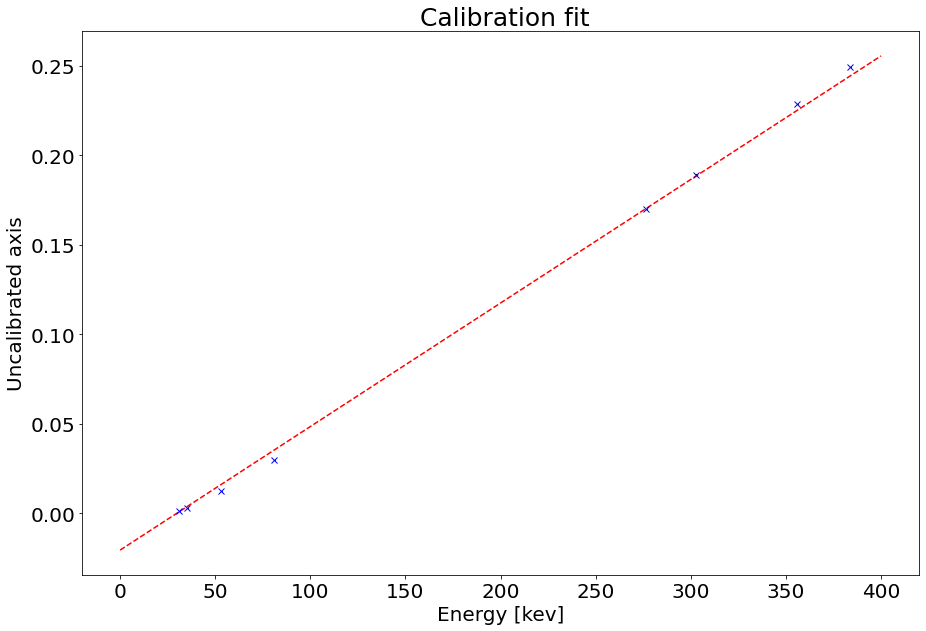

In [21]:
def linear(x, m, q):
  return m*x+q

def Chi2(oss,real,sigma2):
  chi=0
  for i in range(len(oss)):
    chi+=(oss[i]-real[i])**2/sigma2[i]
  return chi

#fitting 
init_vals = [1e-4,-1e-2]  # for [N,mu, wid]
best_vals, covar = curve_fit(linear, E_real_peaks, all_mu,p0=init_vals, sigma=np.sqrt(all_sigmaMu)) 

x=np.linspace(0,400,1000)

plt.figure(figsize=(15,10))
plt.errorbar(E_real_peaks,all_mu,yerr=np.sqrt(all_sigmaMu),fmt="x",capsize=0.5,ecolor="black",color="blue")
plt.plot(x,linear(x,best_vals[0],best_vals[1]),ls="--",color="red")
print("m: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[0],np.sqrt(covar[0][0]),np.sqrt(covar[0][0])*100/best_vals[0]) )
print("q: {:.2e}  +/- {:.2e}    relative:  {:.2f} %".format(best_vals[1],np.sqrt(covar[1][1]),np.sqrt(covar[1][1])*100/abs(best_vals[1])) )

plt.title(" Calibration fit".format(source[1:],len(all_integrals_values)),fontsize=25)
plt.xlabel("Energy [kev]",fontsize=20)
plt.ylabel("Uncalibrated axis",fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig(path_to_plots+"Calibration_fit.png")

#print(covar)
print("Chi squared: {:.3f}".format(Chi2(all_mu,linear(E_real_peaks,best_vals[0],best_vals[1]),all_sigmaMu)))

Residuals calculation and plot

In [22]:
sigma_residuals=np.sqrt(all_sigmaMu+covar[0][0]*E_real_peaks**2+covar[1][1])/np.sqrt(all_sigmaMu)
residuals=(all_mu-linear(E_real_peaks,best_vals[0],best_vals[1]))//np.sqrt(all_sigmaMu)



print("Res: ",residuals)
print("Sigma_Res: ",sigma_residuals)

Res:  [  400.  -276.  -492. -1372.   -25.    68.   391.   208.]
Sigma_Res:  [953.69313684 328.02486011 130.59675275 327.20533834 210.83748198
 344.68423597 550.35917226 220.67209213]


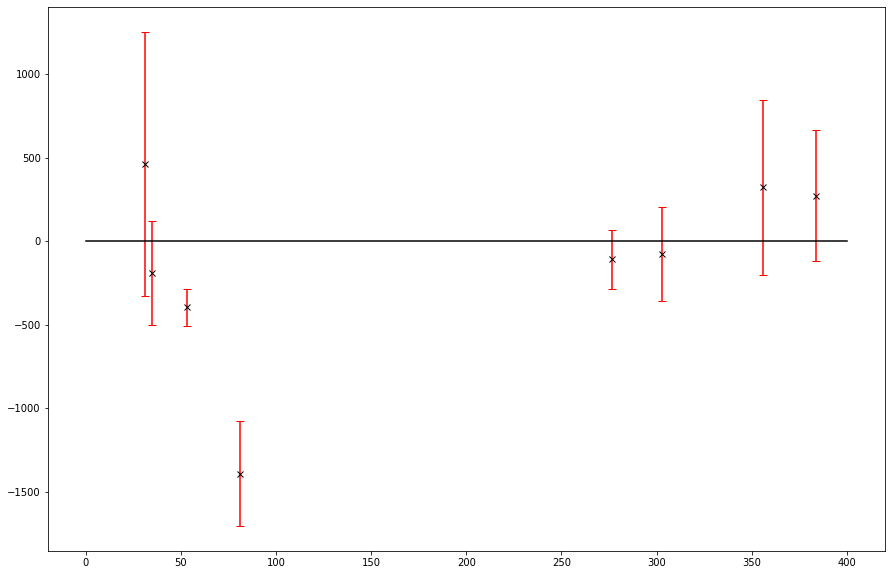

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(E_real_peaks,residuals,yerr=sigma_residuals,fmt="x",ecolor="red",capsize=4,color="black")
#plt.plot(E_real_peaks,residuals,ls="",marker="x",color="red")
energy_axis=np.linspace(0,400,1000)
plt.plot(energy_axis,[0]*len(energy_axis),color="black")
#plt.yticks(np.linspace(-5,5,11),np.linspace(-5,5,11))
#plt.ylim(-5.5,5.5)
plt.show()

In [23]:
def fano(x,S,n):
    #eps=2.96e-3
    return S/x+(n/x)**2

[0.20003174 0.11266197 0.02756624 0.01418054 0.00326513 0.00299432
 0.00274901 0.00291241]
S:  -0.0011948603639209345 sigma_S: 0.002446905579793408
n_e:  1.1335931055242774 sigma_n_e: 0.2518808337492115
Fano:  -0.40366904186518054 sigma_Fano: 0.8266572904707459


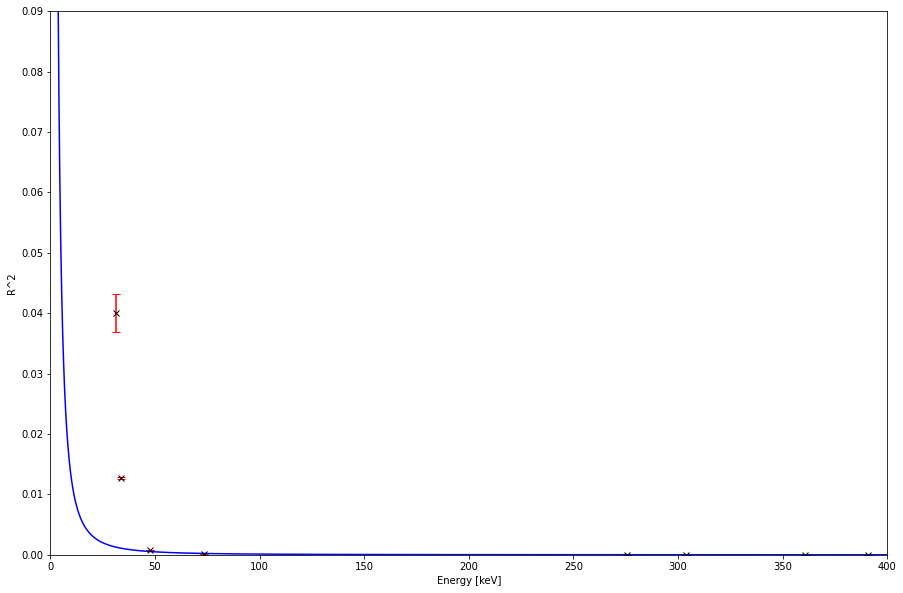

In [26]:
init_vals_fano = [0.1,1]  

# (all_mu-linear(E_real_peaks,best_vals[0],best_vals[1]))//np.sqrt(all_sigmaMu)
#err_fano=np.sqrt(   (((2*all_sigma)**2)*all_sigmaSigma+((2*best_vals[1])**2)*covar[1][1])/best_vals[0]**2 + (2*((abs(all_sigma)-best_vals[1])/best_vals[0]**3))**2  )/E_real_peaks


#R=(abs(all_sigma)-best_vals[1])/(all_mu - best_vals[1])

#err_rel_num=np.sqrt(all_sigmaSigma+covar[1][1])/(abs(all_sigma)-best_vals[1])
#err_rel_den=np.sqrt(all_sigmaMu+covar[0][0])/(all_mu - best_vals[1])

R=abs(all_sigma)/(all_mu )

print(R)

err_rel_num=np.sqrt(all_sigmaSigma)/(abs(all_sigma))
err_rel_den=np.sqrt(all_sigmaMu)/(all_mu )

err_R=(err_rel_num+err_rel_den)*R

err_fano=2*err_R*R

params_bound=([-np.inf,-np.inf],[np.inf,np.inf])

calibrated_mu=(all_mu - best_vals[1])/best_vals[0]

best_vals_fano, covar_fano = curve_fit(fano, calibrated_mu, R**2,sigma=err_fano,p0=init_vals_fano,bounds=params_bound) 

x_fano=np.linspace(0,400,10000)

plt.figure(figsize=(15,10))





#plt.plot(E_real_peaks,(abs(all_sigma)-best_vals[1])/best_vals[0],ls="",marker="x",markersize=8,color="black") #errore in kev sui picchi
#plt.plot(E_real_peaks,(((abs(all_sigma)-best_vals[1])/best_vals[0])/E_real_peaks)**2,ls="",marker="x",markersize=8,color="black") #errore percentuale sui picchi
plt.errorbar(calibrated_mu,R**2,yerr=err_fano,fmt="x",ecolor="red",capsize=4,color="black")



plt.plot(x_fano,fano(x_fano,*best_vals_fano),color="blue")
plt.ylabel("R^2")
plt.xlabel("Energy [keV]")

plt.xlim(0,400)
plt.ylim(0,0.09)
print("S: ",best_vals_fano[0], "sigma_S:",np.sqrt(covar_fano[0][0]))
print("n_e: ",best_vals_fano[1], "sigma_n_e:",np.sqrt(covar_fano[1][1]))
print("Fano: ",best_vals_fano[0]/2.96e-3, "sigma_Fano:",np.sqrt(covar_fano[0][0])/2.96e-3)


plt.show()

Calibrated spectrum

In [ ]:
calibrated_integral_values=(all_integrals_values-best_vals[1])/best_vals[0]

In [ ]:
#numb_bins_calibrated=int(np.sqrt(len(calibrated_integral_values)))+6500
numb_bins_calibrated=5000
energy_lim_sx=0
energy_lim_dx=400

if source[1:]=="Ba133":
    energy_lim_sx=0
    energy_lim_dx=420
elif source[1:]=="Cs137":
    energy_lim_sx=0
    energy_lim_dx=750
elif source[1:]=="Am241":
    energy_lim_sx=0
    energy_lim_dx=100

range_calibrated=(energy_lim_sx,energy_lim_dx)

Calibrated peaks

In [ ]:
peaks_calibrated=[(peaks_unc-best_vals[1])/best_vals[0] for peaks_unc in all_mu]
peaks_calibrated=np.array(peaks_calibrated)

<Figure size 432x288 with 0 Axes>

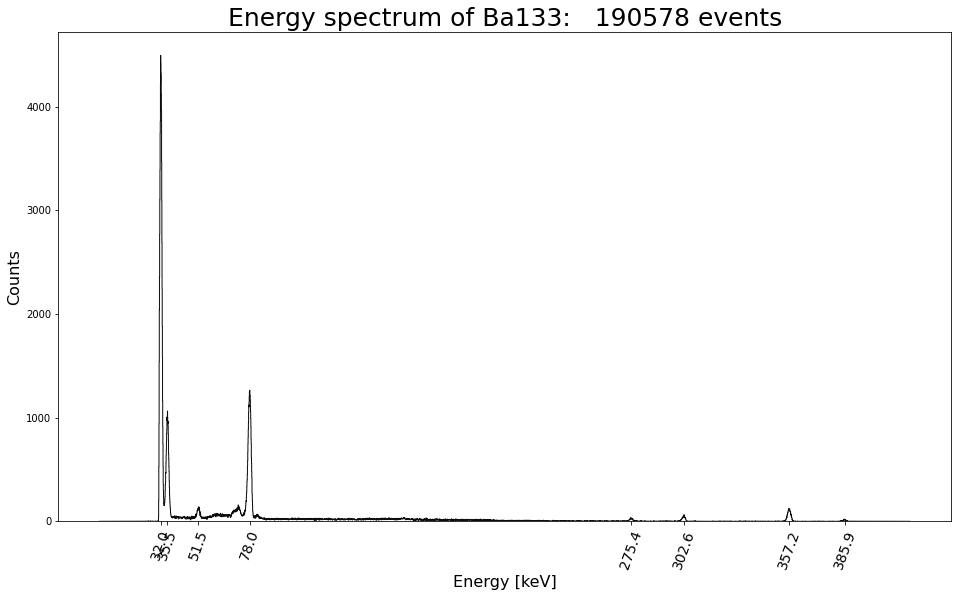

In [ ]:
 #try to change this maybe
plt.clf()
plt.figure(figsize=(16,9))
plt.hist(calibrated_integral_values,bins=numb_bins_calibrated,histtype="step",alpha=0.95,range=range_calibrated,color="black")
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(120,200) #primi picchi
#plt.xlim(0.8,0.9) #ultimi picchi
#plt.yscale("log")

energy=np.linspace(energy_lim_sx,energy_lim_dx,num=20)
np.append(energy,peaks_calibrated)


plt.xticks(peaks_calibrated,label=peaks_calibrated,color="black",rotation=70,fontsize=14)
#plt.xticks(energy,label=energy,color="black")

k=0
for x_peak in peaks_calibrated:
  #plt.arrow(x_peak,0,0,all_N[k],head_length=0,width=0.0002,color="red",ls="-.")
  k+=1

plt.title("Energy spectrum of {:s}:   {:d} events".format(source[1:],len(calibrated_integral_values)),fontsize=25)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("Counts",fontsize=16)
#plt.grid(color="black",ls="-",linewidth=0.4)


#plt.savefig(path_to_plots+source[1:]+"_calibrated_spectrum_noGrid.png")
plt.show()

-----------------------------------------------------------------

-----------------------------------------------------------------          

-----------------------------------------------

-----------------------------------------------------------------          

-----------------------------------------------

Plotting other calibrated spectra 

In [ ]:
###########################################
#                                         #
#    CHANGE ONLY THIS CELL IN THE CODE    #
#                                         #
###########################################

data_dir="drive/MyDrive/Lab HPGE/Data"        
source2="/Na22"                               
detector2="/Ge"                                
threshold_caen2="500"                         


gain_preampl2="30" #useful only for germanium detector

In [ ]:
threshold2="/THR_"+threshold_caen2
gain2="__GAIN_"+gain_preampl2


if detector2[1:]=="Ge":
    path_to_directory2=data_dir+detector2+source2+threshold2+gain2   # do not change this. Change the part above
elif detector2[1:]=="NaI":
    path_to_directory2=data_dir+detector2+source2+threshold2       # do not change this. Change the part above

In [ ]:
if detector2[1:]=="Ge":
    file_name_all2=detector2+"_"+source2[1:]+"_"+threshold_caen2+"_g"+gain_preampl2+"_"+"all.txt"
elif detector2[1:]=="NaI":
    file_name_all2=detector2+"_"+source2[1:]+"_"+threshold_caen2+"_"+"all.txt"
else:
    print("Detector not found")

In [ ]:
nomefile2=path_to_directory2+file_name_all2 
f=open(nomefile2,"r")
lines=f.readlines() #leggo linee del file
colonna1=[]

for riga in lines:
    colonna1.append(riga.split()[0])
f.close()

all_integrals_values_2 = np.asarray(colonna1, dtype=np.float64)

In [ ]:
calibrated_integral_values_2=(all_integrals_values_2-best_vals[1])/best_vals[0]

In [ ]:
#numb_bins_calibrated_2=int(np.sqrt(len(all_integrals_values_2)))
numb_bins_calibrated_2=1800

if source2[1:]=="Ba133":
    energy_lim_sx2=0
    energy_lim_dx2=420
elif source2[1:]=="Cs137":
    energy_lim_sx2=0
    energy_lim_dx2=750
elif source2[1:]=="Am241":
    energy_lim_sx2=0
    energy_lim_dx2=100
elif source2[1:]=="Na22":
    energy_lim_sx2=0
    energy_lim_dx2=1500    

range_calibrated_2=(energy_lim_sx2,energy_lim_dx2)

Total events: 78659





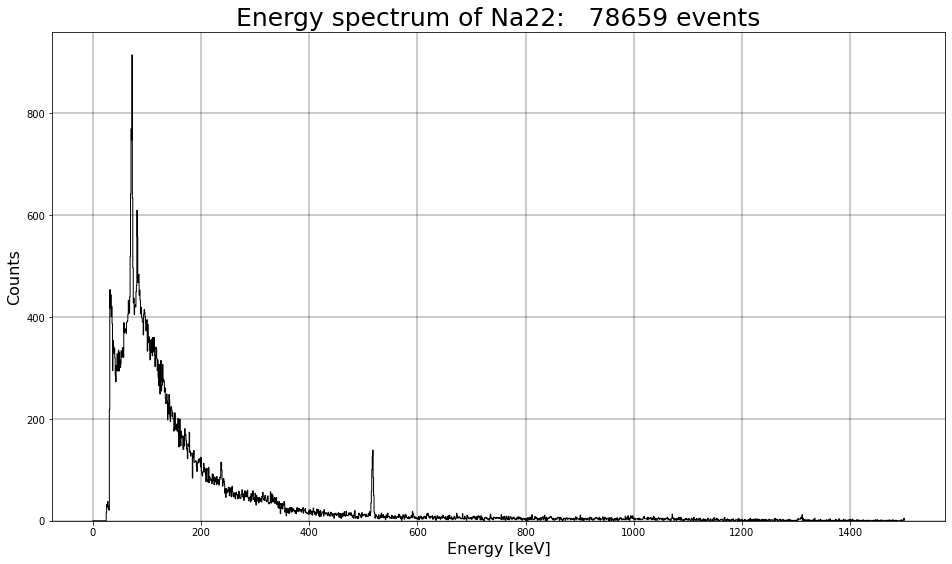

In [ ]:
len_tot_2=len(all_integrals_values_2)
print("Total events: {:d}".format(len_tot_2))
print("\n\n")

#try to change this maybe
plt.figure(figsize=(16,9))
plt.hist(calibrated_integral_values_2,bins=numb_bins_calibrated_2,histtype="step",range=range_calibrated_2,color="black")
#plt.ylim(0,200)   #to cut the y axis 
#plt.xlim(59,60) #primi picchi
#plt.xlim(650,850) #ultimi picchi
#plt.yscale("log")

plt.title("Energy spectrum of {:s}:   {:d} events".format(source2[1:],len(calibrated_integral_values_2)),fontsize=25)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("Counts",fontsize=16)
plt.grid(color="black",ls="-",linewidth=0.4)


#plt.savefig(path_to_plots+source2[1:]+"_calibrated_spectrum_log.png")
plt.show()

Simulations on real data:

In [ ]:
#!wget https://github.com/MohamedElashri/HEP-ML/releases/download/ROOT/ROOT.tar.zip
#!unzip /content/ROOT.tar.zip
#!tar -xf  ROOT.tar
#!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion
#!pip install root_numpy # optional if you want to convert Trees to numpy arrays and other things like that



########################## Folder root_build uploaded in google drive ###################



###############################################################################
#                                                                             #
#  RUN THIS CELL ONLY IF THERE IS NO root_build file in the local directory   #
#                                                                             #
#   IF THE CELL BELOVE DOESN'T WORK ANYMORE JUST UNCOMMENT THE FIRST 5 LINES  #
#   ABOVE AND DELETE path_to_simulations IN THE COMMANDS BELOW                #
#                                                                             #
###############################################################################

In [ ]:
#!apt-get install git dpkg-dev cmake g++ gcc binutils libx11-dev libxpm-dev libxft-dev libxext-dev tar gfortran subversion
#IF IT  DOESN'T WORK UNCOMMENT LINE ABOVE

import sys
sys.path.append(path_to_simulations+"/root_build/")
sys.path.append(path_to_simulations+"/root_build/bin/")
sys.path.append(path_to_simulations+"/root_build/include/")
sys.path.append(path_to_simulations+"/root_build/lib/")
import ctypes
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libCore.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libThread.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libRIO.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libNet.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libImt.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libTree.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMathCore.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMatrix.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libHist.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGraf.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGpad.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libGraf3d.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libMultiProc.so')
ctypes.cdll.LoadLibrary(path_to_simulations+'/root_build/lib//libTreePlayer.so')

import ROOT

Welcome to JupyROOT 6.14/04


In [ ]:
source_sim="/Na22"
active_detectors=12  # 1 for One detector   not 1 for All detectors


path_to_simulations_source=path_to_simulations+source_sim

if active_detectors==1:
  file_name_sim=source_sim+"_O.root"
else:
  file_name_sim=source_sim+"_A.root"

In [ ]:
file_sim = ROOT.TFile.Open(path_to_simulations_source+file_name_sim,"READ")

In [ ]:
tree_en=file_sim.Get("Scoring")
numb_of_events=tree_en.GetEntries()
print("There are {:d} events in this simulation run using {:s}".format(numb_of_events,source_sim[1:]))

There are 62489 events in this simulation run using Na22


In [ ]:
i=0
energy_values_sim=np.zeros(numb_of_events)

for event in tree_en:
  energy_values_sim[i]=event.fEnergy*1000 # in keV
  i+=1

In [ ]:
numb_bins_calibrated=3000 # to be added at the end for the other one 
#numb_bins_sim=int(np.sqrt(numb_of_events))
numb_bins_sim=1500

if source_sim[1:]=="Ba133":
    energy_lim_sx_sim=25
    energy_lim_dx_sim=400
elif source_sim[1:]=="Cs137":
    energy_lim_sx_sim=0
    energy_lim_dx_sim=750
elif source_sim[1:]=="Am241":
    energy_lim_sx_sim=0
    energy_lim_dx_sim=100
elif source_sim[1:]=="Na22":
    energy_lim_sx_sim=0
    energy_lim_dx_sim=1500      


range_calibrated_sim=(energy_lim_sx_sim,energy_lim_dx_sim)

There are 62489 events in this simulation run using Na22


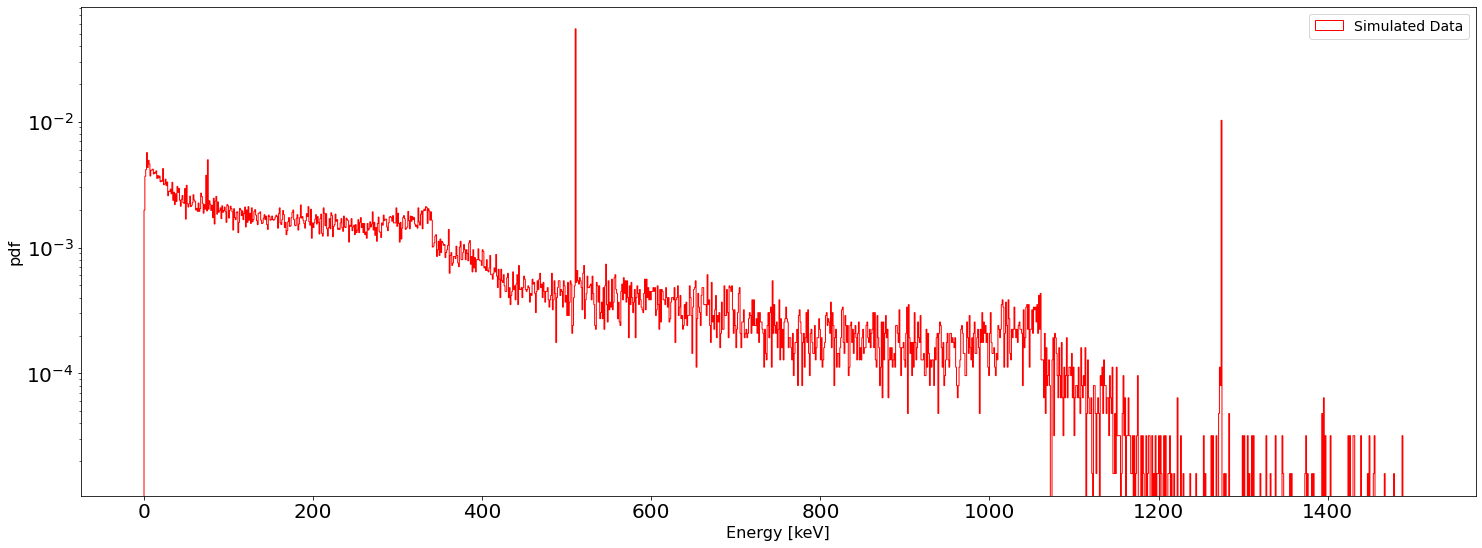

In [ ]:
print(colored("There are {:d} events in this simulation run using {:s}","red").format(numb_of_events,source_sim[1:]))
print(colored("There are {:d} events in this real run using {:s}","blue").format(len_tot,source[1:]))

plt.figure(figsize=(25,9))
plt.hist(energy_values_sim,bins=numb_bins_sim,histtype="step",range=range_calibrated_sim,color="red",label="Simulated Data",density=True)
plt.hist(calibrated_integral_values,bins=numb_bins_calibrated,histtype="step",range=range_calibrated_sim,color="blue",label="Real Data",density=True)
plt.yscale("log")

plt.title("Ba 133 spectrum".format(source[1:],len(all_integrals_values)),fontsize=25)
plt.xlabel("Energy [keV]",fontsize=16)
plt.ylabel("pdf",fontsize=16)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=14)

#plt.savefig(path_to_plots+"SIM_Data_spectrum.png")

#plt.xlim(0,200)

plt.show()

Smearing gaussiano

In [ ]:
i=0
energy_values_sim=np.zeros(numb_of_events)
for event in tree_en:
  energy_values_sim[i]=event.fEnergy*1000 # in keV
  i+=1

S=best_vals_fano[0]
S=0
n_e=np.sqrt(best_vals_fano[1])
#S=0.2*2.96e-3
#n_e=1

Sigma_E=np.sqrt(S*energy_values_sim+n_e**2)
Energy_offset_simulation=np.random.normal([0]*numb_of_events,Sigma_E,size=numb_of_events)
energy_smeared=energy_values_sim+Energy_offset_simulation

There are 50871 events in this simulation run using Ba133
There are 11435 events in this real run using Am241


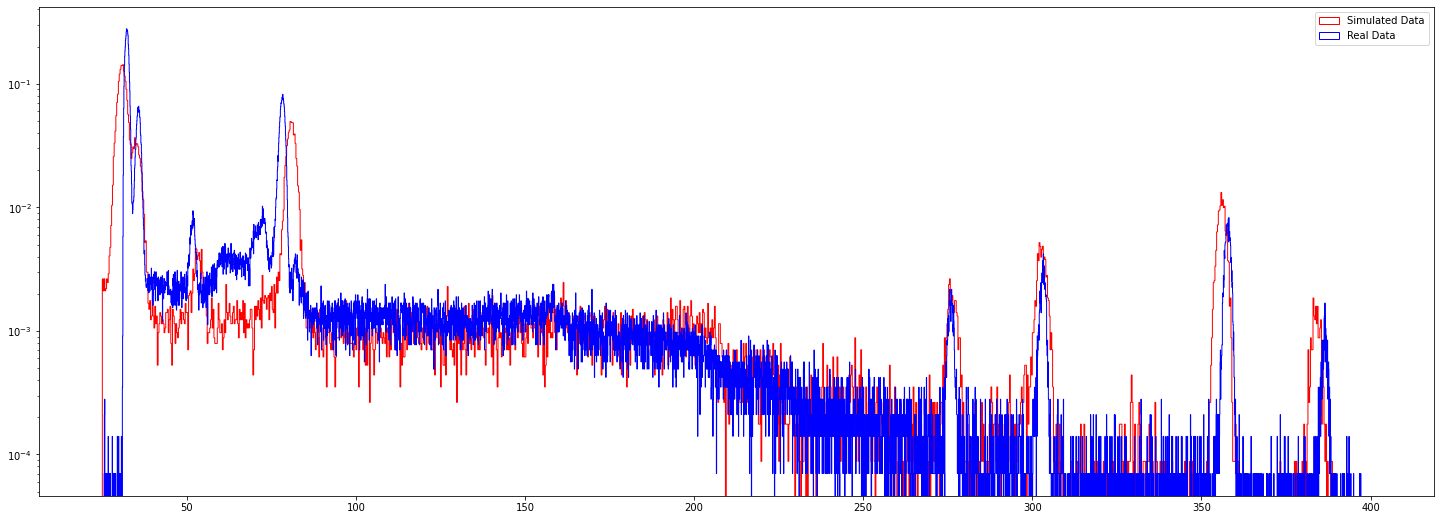

In [ ]:
print(colored("There are {:d} events in this simulation run using {:s}","red").format(numb_of_events,source_sim[1:]))
print(colored("There are {:d} events in this real run using {:s}","blue").format(len_tot,source[1:]))

plt.figure(figsize=(25,9))
plt.hist(energy_smeared,bins=numb_bins_sim,histtype="step",range=range_calibrated_sim,color="red",label="Simulated Data",density=True)
plt.hist(calibrated_integral_values,bins=numb_bins_calibrated,histtype="step",range=range_calibrated_sim,color="blue",label="Real Data",density=True)
plt.yscale("log")
plt.legend()
plt.show()